In [1]:
# !pip install -q lungmask
# !pip install -q SimpleITK
# !pip3 install -q torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip3 install torch==2.0.0 torchvision==0.15.0 --index-url https://download.pytorch.org/whl/cu118
#!pip uninstall -y torch torchvision
# # 

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 14.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 30.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 68.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=90004 sha256=de945f9955901e27fd3b301dc85e62c799d8feaf0386ee65e828e03c21a937b7
  Stored in directory: /home/msalehjahromi/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit


In [2]:
#!pip install torch torchvision

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
from typing import Sequence
import torch
from torchvision import transforms
warnings.filterwarnings('ignore')

## CTNetTransform ------> DINO

Order:
1. `transforms.py`
2. `augmentations.py`
3. `decoders.py`


In [4]:
global_crops_scale = [0.4, 1.0]
local_crops_scale = [0.25, 0.4]
local_crops_number = 8
global_crops_size = 448
local_crops_size = 192

print('###################################')
print('Using data augmentation parameters:')
print(f'global_crops_scale: {global_crops_scale}')
print(f'local_crops_scale: {local_crops_scale}')
print(f'local_crops_number: {local_crops_number}')
print(f'global_crops_size: {global_crops_size}')
print(f'local_crops_size: {local_crops_size}')
print('###################################')


###################################
Using data augmentation parameters:
global_crops_scale: [0.4, 1.0]
local_crops_scale: [0.25, 0.4]
local_crops_number: 8
global_crops_size: 448
local_crops_size: 192
###################################


(512, 512, 3) (512, 512, 3)
shape of the image masks is : (512, 512, 3), min: 5e-05 max: 0.99995


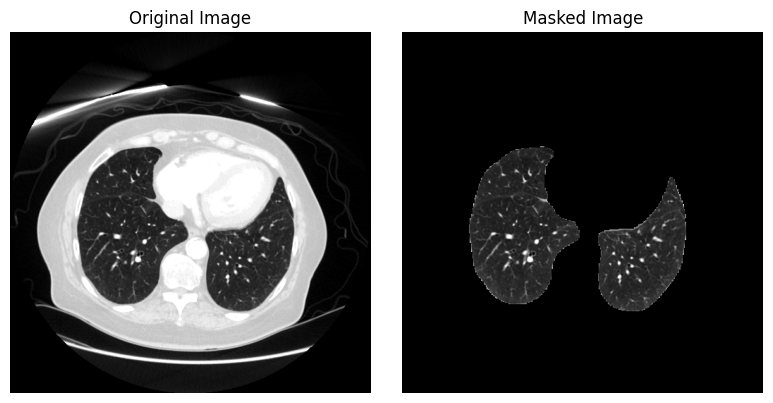

In [5]:
npz_file_path = "/rsrch7/home/ip_rsrch/wulab/Lung_Foundation_Model_Data_/Batchs_NPY/3SlicesChunks/Batch_1/Chunk1/164291_21208277_11_008.npz"
#npz_file_path = "/rsrch7/home/ip_rsrch/wulab/Lung_Foundation_Model_Data_/Batchs_NPY/3SlicesChunks/Batch_1/Chunk1/163654_12878093_16_029.npz"
image_data = np.load(npz_file_path, mmap_mode='r')["array"]
mask_data = np.load(npz_file_path, mmap_mode='r')["mask"]
print(image_data.shape, mask_data.shape)

# Preprocess image data
vmin, vmax, eps = -1000., 150, 0.00005 
image_data = np.clip(image_data, vmin, vmax)
image_data = (image_data - vmin) / (vmax - vmin)
image_data = np.clip(image_data, eps, 1-eps)

# Verify the shape and min/max values
print(f'shape of the image masks is : {image_data.shape}, min: {np.min(image_data)} max: {np.max(image_data)}')

# Extract single slices for visualization
image_masked = image_data * mask_data
image_plt = image_data[:, :, 1]
image_plt_masked = image_masked[:, :, 1]

# Plot images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

# Original Image
axes[0].imshow(image_plt, vmin=0.0, vmax=1.0, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')  # Remove axes for a clean look

# Masked Image
axes[1].imshow(image_plt_masked, vmin=0.0, vmax=1.0, cmap='gray')
axes[1].set_title("Masked Image")
axes[1].axis('off')  # Remove axes for a clean look

# Show the images
plt.tight_layout()
plt.show()


In [5]:
from torchvision import transforms
class MaybeToTensor(transforms.ToTensor):
    def __call__(self, pic):
        if isinstance(pic, torch.Tensor):
            return pic
        return super().__call__(pic)

In [6]:
geometric_augmentation_global = transforms.Compose([transforms.RandomResizedCrop(global_crops_size, scale=global_crops_scale,
                                                    interpolation=transforms.InterpolationMode.BICUBIC),
                                                    transforms.RandomHorizontalFlip(p=0.5),])

geometric_augmentation_global = transforms.Compose([
                transforms.RandomRotation(degrees=45),
                transforms.RandomResizedCrop(global_crops_size, scale=global_crops_scale, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
            ])

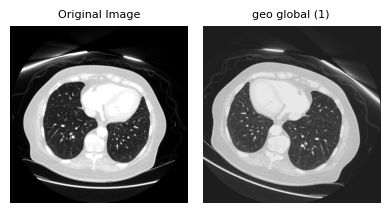

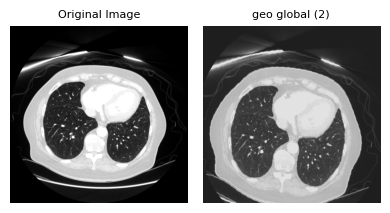

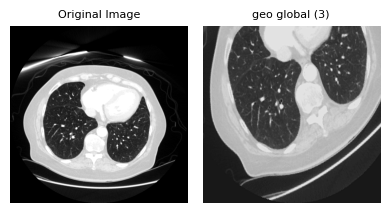

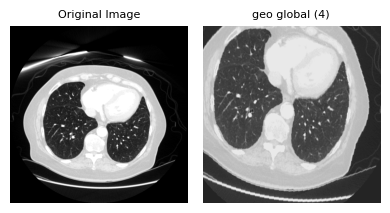

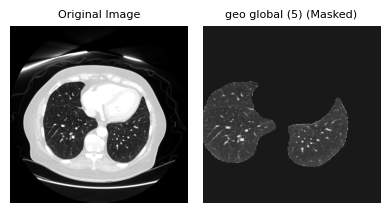

In [7]:
import random

# Number of augmentations
num_augmentations = 5

# Loop over augmentations
for i in range(num_augmentations):
    # Convert image data to tensor
    image_tensor = MaybeToTensor()(image_data)
    mask_tensor = MaybeToTensor()(mask_data)
    
    # Apply the mask with 50% probability
    if random.random() < 0.2:  # 50% chance
        masked_image_tensor = image_tensor * mask_tensor
        augmented_image = geometric_augmentation_global(masked_image_tensor)
        title_suffix = " (Masked)"
    else:
        augmented_image = geometric_augmentation_global(image_tensor)
        title_suffix = ""

    # Prepare the figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))

    # Original Image
    axes[0].imshow(image_data[:, :, 1], cmap='gray')  # Assuming slice at index 1
    axes[0].axis('off')
    axes[0].set_title("Original Image", fontsize = 8)

    # Augmented Image
    augmented_image_np = augmented_image.permute(1, 2, 0).numpy()  # Convert to numpy
    augmented_image_slice = augmented_image_np[:, :, 1]  # Take channel 1 for grayscale visualization
    axes[1].imshow(augmented_image_slice, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f"geo global ({i+1}){title_suffix}", fontsize = 8)

    # Clean layout
    plt.tight_layout()
    plt.show()

In [8]:
# Use timm's names
IMAGENET_DEFAULT_MEAN = (0.5, 0.5, 0.5)
IMAGENET_DEFAULT_STD = (0.5, 0.5, 0.5)

def make_normalize_transform(
    mean: Sequence[float] = IMAGENET_DEFAULT_MEAN,
    std: Sequence[float] = IMAGENET_DEFAULT_STD,
) -> transforms.Normalize:
    return transforms.Normalize(mean=mean, std=std)

class GaussianBlur(transforms.RandomApply):
    def __init__(self, *, p: float = 0.5, radius_min: float = 0.1, radius_max: float = 1.0):
        # NOTE: torchvision is applying 1 - probability to return the original image
        keep_p = 1 - p
        transform = transforms.GaussianBlur(kernel_size=9, sigma=(radius_min, radius_max))
        super().__init__(transforms=[transform], p=keep_p)

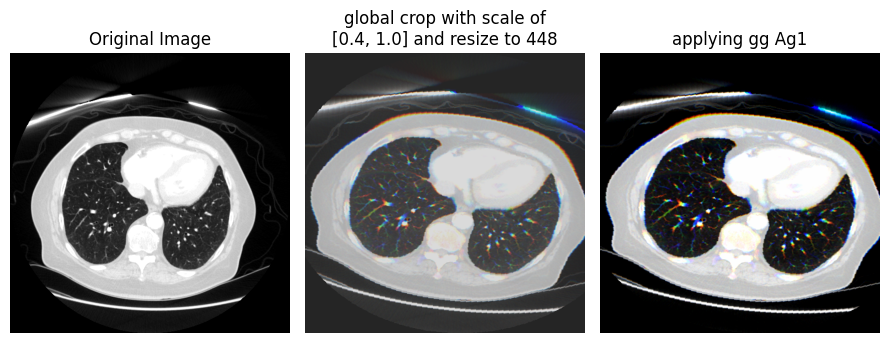

In [9]:
image_T = MaybeToTensor()(image_data)
im1_base = geometric_augmentation_global(image_T)
color_jittering = transforms.Compose([transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],p=0.8,),
                                      transforms.RandomGrayscale(p=0.2),])
# Ag1
global_transfo1_extra = GaussianBlur(p=1.0)
normalize = transforms.Compose([make_normalize_transform(),])
global_transfo1 = transforms.Compose([color_jittering, global_transfo1_extra, normalize])
global_crop_1 = global_transfo1(im1_base)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))  # Adjust figsize for image size

# Display the first image
axes[0].imshow(image_plt, cmap="gray")
axes[0].axis('off')  # Turn off axis labels
axes[0].set_title("Original Image")  # Optional title

# Display the second image
im1_base_plt = im1_base.permute(1, 2, 0).numpy().copy() 
im1_base_plt = (im1_base_plt - np.min(im1_base_plt)) / (np.max(im1_base_plt) - np.min(im1_base_plt))
axes[1].imshow(im1_base_plt)
axes[1].axis('off')  
axes[1].set_title(f"global crop with scale of\n{global_crops_scale} and resize to {global_crops_size}")   

global_crop_1_plt = global_crop_1.permute(1, 2, 0).numpy().copy()
global_crop_1_plt = (global_crop_1_plt - np.min(global_crop_1_plt)) / (np.max(global_crop_1_plt) - np.min(global_crop_1_plt))
axes[2].imshow(global_crop_1_plt)
axes[2].axis('off')  
axes[2].set_title("applying gg Ag1")  

# Show the plot
plt.tight_layout()
plt.show()

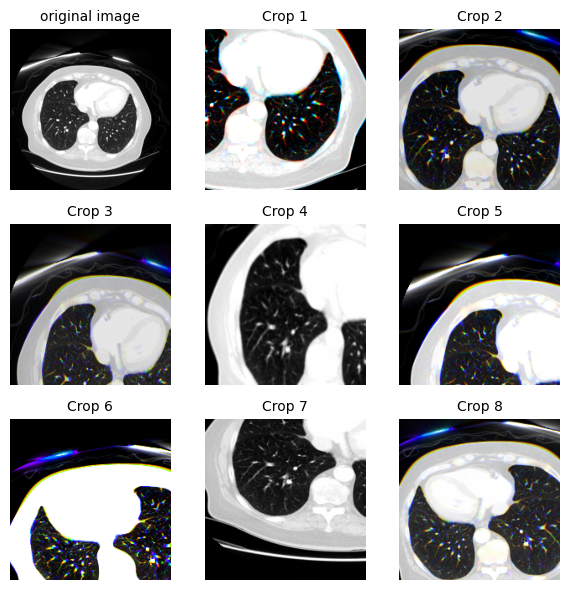

In [10]:
image_T = MaybeToTensor()(image_data)
# gl
geometric_augmentation_local = transforms.Compose([transforms.RandomResizedCrop(local_crops_size, scale=local_crops_scale, interpolation=transforms.InterpolationMode.BICUBIC),
                                                   transforms.RandomHorizontalFlip(p=0.5),])
local_transfo_extra = GaussianBlur(p=0.5)
local_transfo = transforms.Compose([color_jittering, local_transfo_extra, normalize])
local_crops = [local_transfo(geometric_augmentation_local(image_T)) for _ in range(local_crops_number)]
local_crops_plt = [image_plt]
for lcl_crop in local_crops:
    lcl_crop_plt = lcl_crop.permute(1, 2, 0).numpy().copy() 
    lcl_crop_plt = (lcl_crop_plt - np.min(lcl_crop_plt)) / (np.max(lcl_crop_plt) - np.min(lcl_crop_plt))
    local_crops_plt.append(lcl_crop_plt)
    
fig, axes = plt.subplots(3, 3, figsize=(6, 6))  # Adjust figsize as needed

# Plot each image
for i, ax in enumerate(axes.flat):  # Flatten axes for easy iteration
    ax.imshow(local_crops_plt[i], cmap="gray")  # Display the image
    ax.axis('off') 
    if i == 0:
        ax.set_title(f"original image",fontsize=10)
    else:
        ax.set_title(f"Crop {i}", fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

5e-05 0.99995


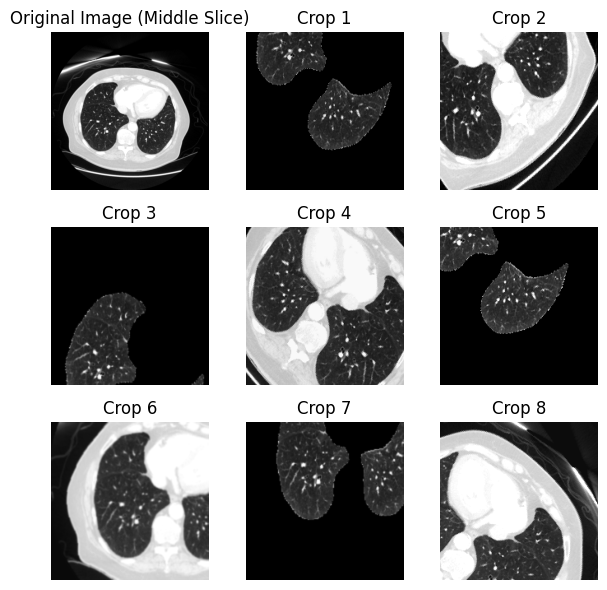

In [11]:
# import random
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from torchvision import transforms
print(image_data.min(), image_data.max())
# Convert image and mask data to tensors
image_T = MaybeToTensor()(image_data).to(torch.float32)  # Shape: [C, H, W]
mask_T = MaybeToTensor()(mask_data).to(torch.float32)    # Shape: [1, H, W]

# gg
geometric_augmentation_global = transforms.Compose([
                transforms.RandomRotation(degrees=30),
                transforms.RandomResizedCrop(global_crops_size, scale=global_crops_scale, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
            ])


# gl
geometric_augmentation_local = transforms.Compose([
                               transforms.RandomRotation(degrees=60),
                               transforms.RandomResizedCrop(local_crops_size, scale=local_crops_scale, interpolation=transforms.InterpolationMode.BICUBIC),
                               transforms.RandomHorizontalFlip(p=0.5)])


# global_transfo2_extra = transforms.Compose(
#     [
#         GaussianBlur(p=0.1, radius_min=0.1, radius_max=1.0),
#         transforms.RandomSolarize(threshold=0.1, p=0.2),
#     ]
# )

# Ag1
global_transfo1 = transforms.Compose([color_jittering, global_transfo1_extra, normalize])

# Ag2
### global_transfo1 = transforms.Compose([color_jittering, global_transfo1_extra, normalize])


# Al ( Gaussian blur, color jitter, normalize)
local_transfo_extra = GaussianBlur(p=0.5)

color_jittering = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.09)
color_jittering = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05)
normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
local_transfo = transforms.Compose([ color_jittering, local_transfo_extra, normalize])


# Function to augment image and mask together
def gl_image_and_mask(image, mask):
    """
    Apply geometric augmentations to both the image and mask together.
    After geometric augmentations, apply the mask with 50% probability.
    """
    # Combine image and mask 
    combined = torch.cat([image, mask], dim=0)  # Combined shape: [C+C, H, W]
    # Apply gl
    combined_aug = geometric_augmentation_local(combined)
    # Split the combined tensor back into image and mask
    image_aug = combined_aug[:image.shape[0], :, :]
    mask_aug = combined_aug[image.shape[0]:, :, :]  # Mask is last channel(s)
    # Apply mask with 50% probability
    if random.random() < 0.5 and torch.sum(mask_aug)>3*2000: #####################################################
        image_aug = image_aug * mask_aug
    return image_aug

# # Generate local crops
# local_crops, crop_n = [], 1
# for _ in range(local_crops_number):
#     # gl image and mask
#     aug_image = gl_image_and_mask(image_T, mask_T)
#     # Apply Al
#     aug_image = local_transfo(aug_image)
#     print("crop", crop_n, torch.isnan(aug_image).any().item(), aug_image.min().item(), aug_image.max().item())
#     print( torch.sum(aug_image>-.95))
#     local_crops.append(aug_image)
#     crop_n += 1


# method 1
#local_crops, crop_n = [], 1
# while len(local_crops) < local_crops_number:
#     print("crop", crop_n, torch.isnan(image_T).any().item(), image_T.min().item(), image_T.max().item())
#     # Generate augmented image
#     aug_image = gl_image_and_mask(image_T, mask_T)
#     aug_image = local_transfo(aug_image)

#     # Efficient validation: Check for NaN or Inf only once
#     #if torch.isfinite(aug_image).all():
#     print("crop", crop_n, torch.isnan(aug_image).any().item(), aug_image.min().item(), aug_image.max().item())
#     print()
#     local_crops.append(aug_image)
#     crop_n += 1
    
# method 2
# local_crops = []
# for i in range(local_crops_number):
#     aug_image = gl_image_and_mask(image_T, mask_T)
#     aug_image = local_transfo(aug_image)
#     local_crops.append(aug_image)
    
# method 3
local_crops = [local_transfo(gl_image_and_mask(image_T, mask_T)) for _ in range(local_crops_number)]



# Prepare images for display
local_crops_plt = []

# Extract middle slice of the original image for display
middle_index = image_data.shape[2] // 2
original_slice = image_data[:, :, middle_index]
local_crops_plt.append(original_slice)

# Process augmented crops for display
for crop in local_crops:
    crop_np = crop.permute(1, 2, 0).numpy().copy()  # [H, W, C]
    #crop_np = (crop_np - np.min(crop_np)) / (np.max(crop_np) - np.min(crop_np))  # Normalize for display
    crop_middle = crop_np[:, :, 1]  # Extract middle channel (since 3-channel image)
    local_crops_plt.append(crop_middle)

# Plot original image and local crops
fig, axes = plt.subplots(3, 3, figsize=(6, 6))  # Adjust grid size as needed

for i, ax in enumerate(axes.flat):
    if i < len(local_crops_plt):
        vmin=0 if i==0 else -1
        ax.imshow(local_crops_plt[i], vmin=vmin, vmax=1, cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title("Original Image (Middle Slice)")
        else:
            ax.set_title(f"Crop {i}")
    else:
        ax.axis('off')  # Hide extra axes if not needed

plt.tight_layout()
plt.show()


# gaussian lower!
# why white ? 
# Write a function that does aug outside the lung mask

In [12]:
image_T.float()
image_T.dtype

torch.float32

In [13]:
aug_image.min().item()

NameError: name 'aug_image' is not defined

5e-05 0.99995
mask_T.min() tensor(0.) tensor(1.)


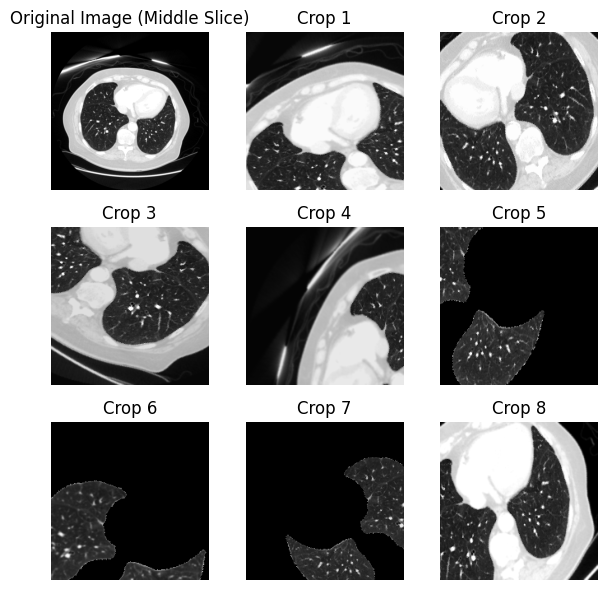

In [14]:
# import random
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from torchvision import transforms
print(image_data.min(), image_data.max())
# Convert image and mask data to tensors
image_T = MaybeToTensor()(image_data).to(torch.float32)  # Shape: [C, H, W]
mask_T = MaybeToTensor()(mask_data).to(torch.float32)    # Shape: [1, H, W]

# gg
geometric_augmentation_global = transforms.Compose([
                transforms.RandomRotation(degrees=30),
                transforms.RandomResizedCrop(global_crops_size, scale=global_crops_scale, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
            ])


# gl
geometric_augmentation_local = transforms.Compose([
                               transforms.RandomRotation(degrees=60),
                               transforms.RandomResizedCrop(local_crops_size, scale=local_crops_scale, interpolation=transforms.InterpolationMode.BICUBIC),
                               transforms.RandomHorizontalFlip(p=0.5)])


# global_transfo2_extra = transforms.Compose(
#     [
#         GaussianBlur(p=0.1, radius_min=0.1, radius_max=1.0),
#         transforms.RandomSolarize(threshold=0.1, p=0.2),
#     ]
# )

# Ag1
global_transfo1 = transforms.Compose([color_jittering, global_transfo1_extra, normalize])

# Ag2
### global_transfo1 = transforms.Compose([color_jittering, global_transfo1_extra, normalize])


# Al ( Gaussian blur, color jitter, normalize)
local_transfo_extra = GaussianBlur(p=0.5)

color_jittering = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.09)
color_jittering = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05)
normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
local_transfo = transforms.Compose([ color_jittering, local_transfo_extra, normalize])


# Function to augment image and mask together
def gl_image_and_mask(image, mask):
    # Combine image and mask 
    combined = torch.cat([image, mask], dim=0)  # Combined shape: [C+C, H, W]
    # Apply gl
    combined_geo = geometric_augmentation_local(combined)
    # Split the combined tensor back into image and mask
    image_geo = combined_geo[:image.shape[0], :, :]
    mask_geo = combined_geo[image.shape[0]:, :, :]  # Mask is last channel(s)
    mask_geo_out = 1 - mask_geo
    image_geo_al = local_transfo(image_geo)
    #image_geo_al = image_geo*mask_geo + image_geo_al*mask_geo_out
    # Apply mask with 50% probability
    if random.random() < 0.5 and torch.sum(mask_geo)>3*2000: #####################################################
        image_geo_al = (image_geo_al+1.)/2.*mask_geo
    else:
        image_geo_al = image_geo*mask_geo + (image_geo_al+1.)/2.*mask_geo_out
    return (image_geo_al-0.5)*2
    
# method 3
print("mask_T.min()",mask_T.min(), mask_T.max())
local_crops = [gl_image_and_mask(image_T, mask_T) for _ in range(local_crops_number)]

# Prepare images for display
local_crops_plt = []

# Extract middle slice of the original image for display
middle_index = image_data.shape[2] // 2
original_slice = image_data[:, :, middle_index]
local_crops_plt.append(original_slice)

# Process augmented crops for display
for crop in local_crops:
    crop_np = crop.permute(1, 2, 0).numpy().copy()  # [H, W, C]
    #crop_np = (crop_np - np.min(crop_np)) / (np.max(crop_np) - np.min(crop_np))  # Normalize for display
    crop_middle = crop_np[:, :, 1]  # Extract middle channel (since 3-channel image)
    local_crops_plt.append(crop_middle)

# Plot original image and local crops
fig, axes = plt.subplots(3, 3, figsize=(6, 6))  # Adjust grid size as needed

for i, ax in enumerate(axes.flat):
    if i < len(local_crops_plt):
        vmin=0 if i==0 else -1
        ax.imshow(local_crops_plt[i], vmin=vmin, vmax=1, cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title("Original Image (Middle Slice)")
        else:
            ax.set_title(f"Crop {i}")
    else:
        ax.axis('off')  # Hide extra axes if not needed

plt.tight_layout()
plt.show()


# gaussian lower!
# why white ? 
# Write a function that does aug outside the lung mask

torch.Size([3, 512, 512])


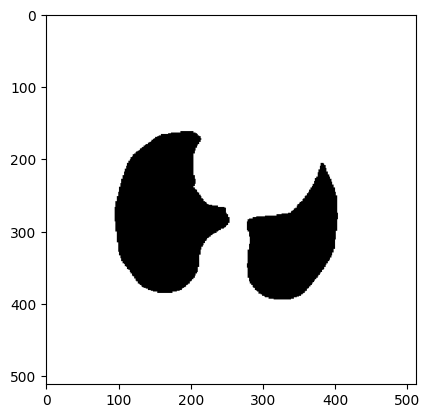

In [15]:
masked_image = mask_T.clone()
print(masked_image.shape)# torch.Size([673543]) I do not want this
plt.imshow(1 - masked_image[0,:,:], cmap="gray")